In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, imageio
import os, glob
from tqdm.notebook import tqdm

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, \
Conv2D, Flatten, TimeDistributed, LSTM

import warnings
warnings.filterwarnings('ignore')

In [9]:
vid = []

for file in glob.glob("data_30/aakkdgsmvl/*.png"):
    frame = imageio.imread(file)
    vid.append(frame)
    
vid = np.array(vid)

In [10]:
vid2 = []

for file in glob.glob("data_30/aassnaulhq/*.png"):
    frame = imageio.imread(file)

    vid2.append(frame)
    
vid2 = np.array(vid2)

In [21]:
test = vid.reshape((160,160,30,3))
test2 = vid2.reshape((160,160,30,3))

In [22]:
a = np.array([test, test2])
a = a.astype('float32')
a /= 255

## Baseline CNN Performance using only 15th Frame 

In [30]:
frames = []

for dir in glob.glob("test_dir/*"):
    frame_path = dir + "/" + os.listdir(dir)[15]
    frame = imageio.imread(frame_path)
    
    frames.append(frame)

In [36]:
frames = np.array(frames)

frames = frames.astype('float32')
frames /= 255

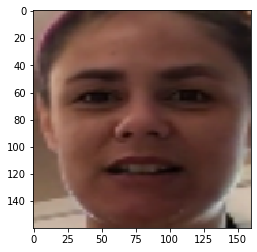

In [43]:
plt.imshow(frames[0]);

In [95]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

for layer in vgg.layers[:-1]:
    layer.trainable = False

In [82]:
vgg.output

<tf.Tensor 'block5_pool_5/MaxPool:0' shape=(?, ?, ?, 512) dtype=float32>

In [96]:
base_model_out = vgg.output

base_model_out = Flatten()(base_model_out)

# Add 3 dense layers so that the model can learn aspects of our new dataset 
# and classify for better results.
base_model_out = Dense(4, activation='relu')(base_model_out)

# Add a final layer with 3 neurons, one for each class in our dataset 
# using a softmabase_model_out activation function:
preds = Dense(2, activation='softmax')(base_model_out)

# Instantiate our final model, where we specify what are the inputs and 
# the outputs will look like
model = Model(inputs = vgg.input, outputs = preds)

In [97]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [98]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0         
__________

In [101]:
X = frames
y = np.array([1, 1, 0, 0, 1])

model.fit(X, y, epochs=10, verbose=2)

Epoch 1/10
 - 1s - loss: 0.6924 - acc: 0.6000
Epoch 2/10
 - 1s - loss: 0.6923 - acc: 0.6000
Epoch 3/10
 - 1s - loss: 0.6921 - acc: 0.6000
Epoch 4/10
 - 1s - loss: 0.6920 - acc: 0.6000
Epoch 5/10
 - 1s - loss: 0.6918 - acc: 0.6000
Epoch 6/10
 - 1s - loss: 0.6916 - acc: 0.6000
Epoch 7/10
 - 1s - loss: 0.6915 - acc: 0.6000
Epoch 8/10
 - 1s - loss: 0.6913 - acc: 0.6000
Epoch 9/10
 - 1s - loss: 0.6912 - acc: 0.6000
Epoch 10/10
 - 1s - loss: 0.6910 - acc: 0.6000


In [107]:
names = []
for dir in os.listdir('test_dir'):
    names.append(dir)

test_metadata = pd.DataFrame({'names':names, 'labels':[1,1,0,0,1]})

test_metadata.to_csv('test_metadata.csv', index=False)

In [136]:
# modified from https://mc.ai/train-keras-model-with-large-dataset-batch-training/

def load_data(df, batch_n, batch_size):
    if batch_n > 0:
        df = pd.read_csv(df, skiprows=batch_n*batch_size, nrows=batch_size, names=['names', 'labels'])
    else:
        df = pd.read_csv(df, skiprows=batch_n*batch_size, nrows=batch_size)
    
    frames = []
    for dir in df['names']:
        frame_path = 'test_dir/' + dir + '/' + os.listdir('test_dir/' + dir)[15]
        frame = imageio.imread(frame_path)

        frames.append(frame)
    
    frames = np.array(frames)
    x = frames.astype('float32')
    x /= 255
    
    y = np.array(df['labels'])
    
    return (x, y)

def batch_generator(df, batch_size, steps):
    batch_n=1
    while True: 
        yield load_data(df,batch_n-1,batch_size)## Yields data
    if batch_n < steps:
        batch_n+=1
    else:
        batch_n=1

In [137]:
a, b = load_data('test_metadata.csv', 0, 2)

In [140]:
batch_size = 2

steps_per_epoch=np.ceil(5/batch_size)
my_training_batch_generator = batch_generator('test_metadata.csv', batch_size, steps_per_epoch)

In [144]:
model.fit_generator(my_training_batch_generator, epochs=10, steps_per_epoch=steps_per_epoch,
                    shuffle=True, verbose=1) # use_multiprocessing=True

Epoch 1/10
3/3 [==============================] - 1s 434ms/step - loss: 0.6476 - acc: 1.0000
Epoch 2/10
3/3 [==============================] - 1s 421ms/step - loss: 0.6443 - acc: 1.0000
Epoch 3/10
3/3 [==============================] - 1s 442ms/step - loss: 0.6411 - acc: 1.0000
Epoch 4/10
3/3 [==============================] - 1s 467ms/step - loss: 0.6379 - acc: 1.0000
Epoch 5/10
3/3 [==============================] - 1s 455ms/step - loss: 0.6348 - acc: 1.0000
Epoch 6/10
3/3 [==============================] - 1s 420ms/step - loss: 0.6317 - acc: 1.0000
Epoch 7/10
3/3 [==============================] - 1s 419ms/step - loss: 0.6286 - acc: 1.0000
Epoch 8/10
3/3 [==============================] - 1s 418ms/step - loss: 0.6255 - acc: 1.0000
Epoch 9/10
3/3 [==============================] - 1s 419ms/step - loss: 0.6225 - acc: 1.0000
Epoch 10/10
3/3 [==============================] - 1s 418ms/step - loss: 0.6195 - acc: 1.0000


In [143]:
model.predict(X, y)

TypeError: only size-1 arrays can be converted to Python scalars

In [102]:
datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

training_set = datagen.flow_from_directory('test_dir', target_size = (160, 160), shuffle=True,
                                             seed=2020, batch_size = 2, class_mode = 'binary',
                                             subset="training")

val_set = datagen.flow_from_directory('test_dir', target_size = (160, 160), shuffle=True,
                                             seed=2020, batch_size = 2, class_mode = 'binary',
                                             subset="validation")

Found 114 images belonging to 5 classes.
Found 26 images belonging to 5 classes.


In [ ]:
# 3D convolution will merge frames together, which may not be desirable.
# https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

In [2]:
from keras.applications.vgg16 import VGG16

vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

for layer in vgg.layers[:-4]:
    layer.trainable = False

Using TensorFlow backend.


In [18]:
from keras.applications.resnet50 import ResNet50

resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

for layer in resnet.layers[:-4]:
    layer.trainable = False

94658560/94653016 [==============================] - 9s 0us/step


In [16]:
num_classes = 2

model = Sequential()

model.add(
    TimeDistributed(vgg)()
)

model.add(
    TimeDistributed(
        Flatten()
    )
)

model.add(LSTM(256, activation='relu', return_sequences=False))

model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(num_classes, activation='softmax'))

AttributeError: 'tuple' object has no attribute 'as_list'

In [8]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [15]:
model._layers

In [ ]:
X_train = a
y_train = np.array([0, 1])

In [15]:
model.fit(X_train, y_train, epochs = 2, verbose = 1)

Epoch 1/2
2/2 [==============================] - 14s 7s/step - loss: 0.6726 - acc: 1.0000
Epoch 2/2
2/2 [==============================] - 9s 5s/step - loss: 1.1921e-07 - acc: 1.0000


In [70]:
sample_frame = imageio.imread("data_30/aakkdgsmvl/000.png")
sample_frame2 = imageio.imread("data_30/aassnaulhq/000.png")

In [35]:
a = np.array([sample_frame, sample_frame2])

img_rows, img_cols = 160, 160

# scale pixel values to be between 0 and 1
a_scaled = a.astype('float32')
a_scaled /= 255

(2, 160, 160, 3)
(2, 160, 160, 3)


In [44]:
y_train.shape

(2,)

In [24]:
a = np.zeros(shape=(160,160,3))
a.shape

(160, 160, 3)

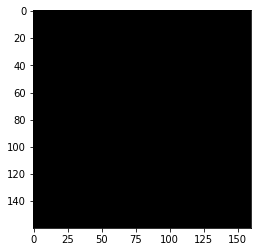

In [25]:
plt.imshow(a);
plt.show()

In [16]:
from tensorflow.keras.applications import Xception

In [17]:
model = Xception(weights='imagenet')

91889664/91884032 [==============================] - 9s 0us/step


In [18]:
model.layers

In [19]:
model.layers[-1].output

<tf.Tensor 'predictions/Softmax:0' shape=(?, 1000) dtype=float32>